In [20]:
import os
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm import tqdm

import cv2

%matplotlib inline

In [2]:
tqdm.pandas()

/home/andreas/miniconda3/lib/python3.8/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
data_path = "../data/raw"

In [26]:
d_train = pd.read_csv(os.path.join(data_path, "new_training_set.csv"),
                      usecols=["title_1", "image_1", "title_2", "image_2", "Label"])

In [27]:
d_test = pd.read_csv(os.path.join(data_path, "new_test_sample.csv"),
                    names=["pair_index", "title_1", "image_1", "title_2", "image_2"], skiprows=1)

In [4]:
d_final = pd.read_csv(os.path.join("../data/final", "new_test_set.csv"),
                    names=["pair_index", "title_1", "image_1", "title_2", "image_2"], skiprows=1)

In [5]:
d_final.shape

(32580, 5)

In [28]:
d_train.shape

(10181, 5)

In [29]:
d_test.shape

(207, 5)

In [ ]:
d_train.head()

In [ ]:
d_test.head()

In [ ]:
d_train.isna().sum()

In [ ]:
d_final.isna().sum()

In [ ]:
d_final.loc[d_final.title_2.isna(), 'title_2'] = d_final.loc[d_final.title_2.isna(), 'title_1']

In [ ]:
d_final.isna().sum()

In [ ]:
d_train.Label.value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.savefig('../figures/label_dist.png')

## Observation

In [ ]:
for idx, row in enumerate(d_train.loc[d_train["Label"] == 1, ["title_1", "title_2", "Label"]].to_dict(orient='records')[:20]):
    print(idx)
    print(row['title_1'])
    print(row['title_2'])
    print("\n")

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(8,12))
for idx, row in enumerate(d_train.loc[d_train["Label"] == 1].reset_index(drop=True).loc[12:14][["image_1", "image_2"]].to_dict(orient="records")):
    img_arr1 = plt.imread(os.path.join("../data/raw/training_img/training_img", row["image_1"]))
    img_arr2 = plt.imread(os.path.join("../data/raw/training_img/training_img", row["image_2"]))
    ax[idx, 0].imshow(img_arr1)
    ax[idx, 1].imshow(img_arr2)

In [ ]:
fig.savefig("../figures/title_diff_label_1.png")

In [ ]:
for row in d_train.loc[d_train["Label"] == 0, ["title_1", "title_2", "Label"]].to_dict(orient='records')[:20]:
    print(row['title_1'])
    print(row['title_2'])
    print("\n")

In [ ]:
fig, ax = plt.subplots(8, 2, figsize=(8,32))
for idx, row in enumerate(d_train.loc[d_train["Label"] == 0].reset_index(drop=True).loc[[0,2,3,5,6,7,9,19], :].to_dict(orient='records')):
    img_arr1 = plt.imread(os.path.join("../data/raw/training_img/training_img", row['image_1']))
    img_arr2 = plt.imread(os.path.join("../data/raw/training_img/training_img", row['image_2']))
    ax[idx, 0].imshow(img_arr1)
    ax[idx, 0].axis('off')
    ax[idx, 1].imshow(img_arr2)
    ax[idx, 1].axis('off')

In [ ]:
fig.savefig("../figures/title_same_label_0.png")

## Need to cleansing

- lower case
- add space before|after symbol like ][
- add space after number

In [ ]:
def text_cleansing(title):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
    
    title = title.lower()
    title = re.sub('(\d+)([a-zA-Z]+)', r'\1 \2', title)
    title = re.sub('\]', r' ] ', title)
    title = re.sub('\[', r' [ ', title)
    title = title.translate(table)
    title = re.sub(r'[^(a-z|A-Z|0-9)]', ' ', title)
    title = " ".join(title.split())
    
    return title

In [ ]:
d_train.dropna(inplace=True)

In [ ]:
d_train['title_1_pre'] = d_train.title_1.apply(text_cleansing)
d_train['title_2_pre'] = d_train.title_2.apply(text_cleansing)

In [ ]:
d_test['title_1_pre'] = d_test.title_1.apply(text_cleansing)
d_test['title_2_pre'] = d_test.title_2.apply(text_cleansing)

In [ ]:
d_final['title_1_pre'] = d_final.title_1.apply(text_cleansing)
d_final['title_2_pre'] = d_final.title_2.apply(text_cleansing)

In [ ]:
d_train[["title_1_pre", "title_2_pre", "Label"]]

In [ ]:
d_test[["title_1_pre", "title_2_pre"]]

### Image

In [6]:
def read_image_size(path):
    try:
        img_path = os.path.join("../data/final/test_img/test_img", path)
        img_arr = Image.open(img_path)
        img_arr = img_arr.resize((224,224))
        img_arr = img_arr.convert('RGB')
        shape = img_arr.size
    except:
        shape = None
    return shape

In [7]:
def read_image(path): 
    img_path = os.path.join("../data/final/test_img/test_img", path)
    img_arr = Image.open(img_path)
    img_arr = img_arr.resize((224,224))
    img_arr = img_arr.convert('RGB')

    return img_arr

In [8]:
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
img_arr = read_image_size(d_train.loc[5253, 'image_2'])

In [ ]:
d_train['image_1_size'] = d_train.image_1.progress_apply(read_image_size)
d_train['image_2_size'] = d_train.image_2.progress_apply(read_image_size)

In [ ]:
d_final['image_1_size'] = d_final.image_1.progress_apply(read_image_size)
d_final['image_2_size'] = d_final.image_2.progress_apply(read_image_size)

In [ ]:
d_final.isna().sum()

In [ ]:
d_train.isna().sum()

In [ ]:
d_train[d_train.image_2_size.isna()]

In [ ]:
d_train["image_1_channel"] = d_train.image_1_size.apply(lambda x: x[2])
d_train["image_2_channel"] = d_train.image_2_size.apply(lambda x: x[2])

In [ ]:
d_train.image_1_channel.value_counts()

In [ ]:
d_train.image_2_channel.value_counts()

In [ ]:
d_train

In [ ]:
d_train.to_csv("../data/text_clean/train.csv", index=False)
d_test.to_csv("../data/text_clean/test.csv", index=False)

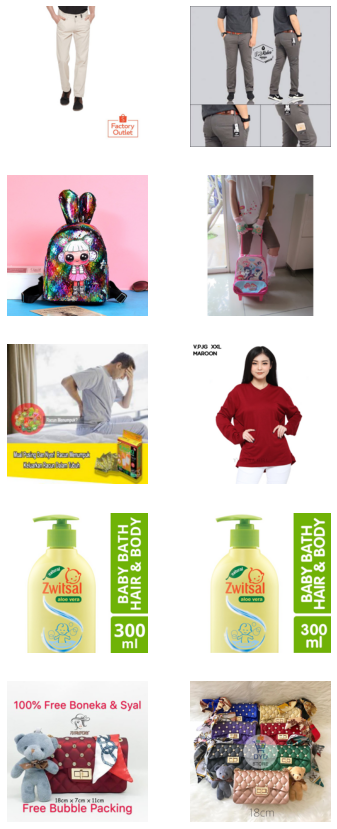

In [25]:
fig, ax = plt.subplots(5,2, figsize=(6,15))
col = 0
row = 0
for index in range(5):
    
    img_arr1 = read_image(d_final.loc[index, 'image_1'])
    img_arr2 = read_image(d_final.loc[index, 'image_2'])
    ax[index, 0].imshow(img_arr1)
    ax[index, 0 ].axis('off')
    ax[index, 1].imshow(img_arr2)
    ax[index, 1 ].axis('off')

## Overlapping

In [ ]:
d_train['title_1_unique'] = d_train.title_1_pre.apply(lambda x: list(set(x.split())))
d_train['title_2_unique'] = d_train.title_2_pre.apply(lambda x: list(set(x.split())))

In [ ]:
d_train['vocab'] = d_train.title_1_unique + d_train.title_2_unique

In [ ]:
d_train['vocab'] = d_train.vocab.apply(lambda x: list(set(x)))

In [ ]:
d_train['num_vocab'] = d_train.vocab.apply(lambda x: len(x))

In [ ]:
def word_overlap(row):
    t1 = set(row['title_1_unique'])
    t2 = set(row['title_2_unique'])
    
    num_intersec = len(t1.intersection(t2))
    return num_intersec

In [ ]:
d_train['num_overlap'] = d_train.apply(word_overlap, axis = 1)

In [ ]:
d_train['percent_overlap'] = (d_train.num_overlap / d_train.num_vocab) * 100

In [ ]:
plt.figure(figsize=(3,5))
sns.boxplot(x = 'Label', y='percent_overlap', data = d_train)
plt.savefig("../figures/word_overlap_boxplot.png")

In [ ]:
d_train.loc[d_train['Label'] == 1, 'percent_overlap'].mean()

In [ ]:
d_train.loc[d_train['Label'] == 0, 'percent_overlap'].mean()